In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def erosion_dilation(img,erosion=True,s=3):
    padding=True
    st = 1
    if padding:
        pad_size = s//2
        img = np.pad(img,(pad_size,pad_size),mode='edge')
    
    h,w = img.shape[0],img.shape[1]
    
    rows = (h - s)//st +1
    cols = (w - s)//st +1
    out = np.zeros((rows,cols))
    
    for i in range(rows):
        for j in range(cols):
            curr = img[i:i+s,j:j+s]
            if erosion:
                out[i,j] = np.min(curr)
            else:
                out[i,j] = np.max(curr)

    return out

def two_pass(img):
    cls = np.zeros(img.shape,dtype=np.int32)
    #1st pass
    neig = []
    c = 0
    if img[0,0]==0:
        cls[0,0] = 0
    else:
        cls[0,0] = 1
        c = 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i==0:
                if j!=0:
                    if img[i,j]==1 and img[i,j-1]==1:
                        cls[i,j] = cls[i,j-1]
                    elif img[i,j]==1:
                        cls[i,j] = c+1
                        c+=1
            else:
                if img[i,j]==1 and img[i-1,j]==1:
                    cls[i,j] = cls[i-1,j]
                    if j>0 and img[i,j-1]==1:
                        cls[i,j] = np.min(np.array([cls[i-1,j],cls[i,j-1]]))
                        if cls[i-1,j]!=cls[i,j-1]:
                            neig.append(cls[i-1,j])
                            neig.append(cls[i,j-1])
                elif img[i,j]==1 and j>0 and img[i,j-1]==1:
                    cls[i,j] = cls[i,j-1]
                elif img[i,j]==1 and j>0 and img[i-1,j-1]==1:
                    cls[i,j] = cls[i-1,j-1]
                elif img[i,j]==1 and j<img.shape[1] and img[i-1,j+1]==1:
                    cls[i,j] = cls[i-1,j+1]
                elif img[i,j]==1:
                    cls[i,j] = c+1
                    c+=1
                    
    #calculate the neigbourhood
    arr = np.arange(c+1)
    
    for i in range(len(neig)//2):
        j = min(neig[2*i],neig[2*i+1])
        k = max(neig[2*i],neig[2*i+1])
        arr[k] = j
    
    for i in range(c+1):
        j = arr[i]
        k = i
        while j!=k:
            k = j
            j = arr[j]
        arr[i] = j
    out = cls.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = arr[cls[i,j]]
    
#     u = np.unique(cls)
    return out
def find_ind(img,c):
    return np.logical_and(np.logical_and((img[:,:,0]-c[0]==0),(img[:,:,1]-c[1]==0)),(img[:,:,2]-c[2]==0))

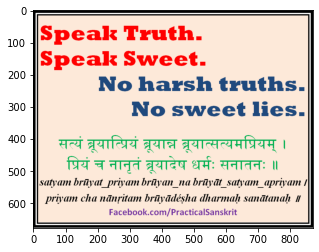

In [3]:
img = cv2.cvtColor(cv2.imread('../images/colourful_text.png'),cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [4]:
c1 = np.array([255,   0,   0])
c2 = np.array([ 31,  73, 125])
c3 = np.array([  0, 176,  80])
c4 = np.array([0,0,0])
c5 = np.array([112,  48, 160])

In [5]:
img1 = np.zeros((img.shape[0],img.shape[1]))
img1[find_ind(img,c1)] = 1
cls = two_pass(img1)
print(np.unique(cls).size)

img1 = np.zeros((img.shape[0],img.shape[1]))
img1[find_ind(img,c2)] = 1
cls = two_pass(img1)
print(np.unique(cls).size)

img1 = np.zeros((img.shape[0],img.shape[1]))
img1[find_ind(img,c3)] = 1
cls = two_pass(img1)
print(np.unique(cls).size)

img1 = np.zeros((img.shape[0],img.shape[1]))
img1[find_ind(img,c4)] = 1
cls = two_pass(img1)
print(np.unique(cls).size-1)

img1 = np.zeros((img.shape[0],img.shape[1]))
img1[find_ind(img,c5)] = 1
cls = two_pass(img1)
print(np.unique(cls).size)

25
28
80
254
37


In [6]:
# _,img = cv2.threshold(cv2.cvtColor(cv2.imread('DIP_2019_A4/objects.png'),cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)
def extracter(img,count=1):
    out = np.zeros(img.shape,dtype=int)
    img_inv = 255 - img
    cls = two_pass(img//255)
    arr = np.unique(cls)
    arr = arr[1:]
    cls_inv = two_pass(img_inv//255)
    arr_inv = np.unique(cls_inv)
    arr_inv = arr_inv[2:]

    ind = np.zeros(arr_inv.size)
    #get the label of the connected component of the object surrounding each hole
    for i in range(arr_inv.size):
        a = np.where(cls_inv==arr_inv[i])
        k = a[0][0]
        k1 = a[0][-1]
        l = a[1][0]
        ind[i] = cls[k-1,l]
    ind,cou = np.unique(ind,return_counts=True)

    for i in range(ind.size):
        if cou[i]==count:
            out[cls==ind[i]] = 1

    fig = plt.figure()
    fig.set_size_inches(10, 10)
    plt.imshow(out)
    fig.add_subplot(121)
    plt.imshow(img,'gray')
    plt.subplot(1,2,2)
    plt.imshow(out,'gray')
    plt.show() 

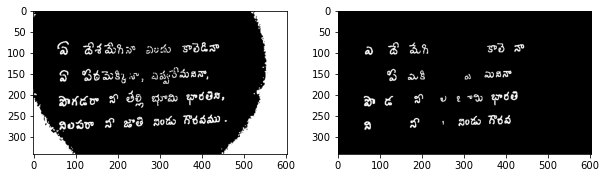

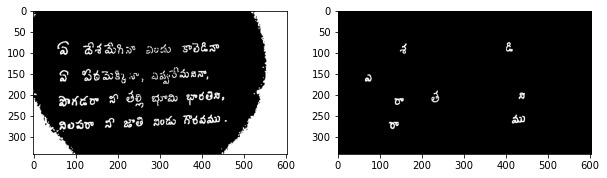

In [7]:
img = cv2.cvtColor(cv2.imread('../images/telugu.jpeg'),cv2.COLOR_BGR2RGB)
a = img[:,:,2]
_,img = cv2.threshold(a,110,255,cv2.THRESH_BINARY)
img = erosion_dilation(img,erosion=True,s=2)
img = 255 - img
extracter(img,1)
extracter(img,2)

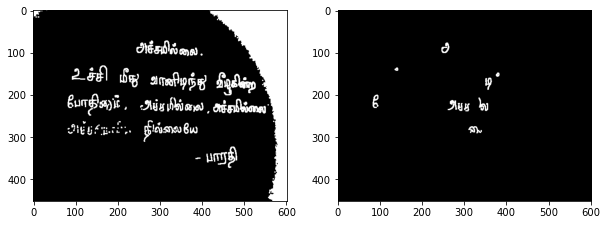

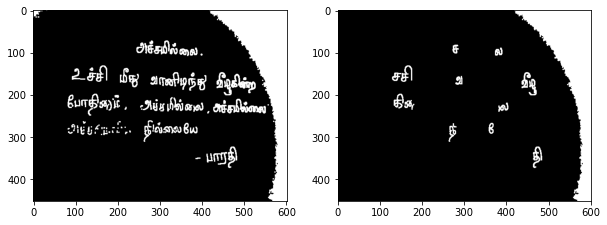

In [8]:
img = cv2.cvtColor(cv2.imread('../images/tamil.jpeg'),cv2.COLOR_BGR2RGB)
a = img[:,:,2]
_,img = cv2.threshold(a,200,255,cv2.THRESH_BINARY)
img = erosion_dilation(img,erosion=True,s=3)
img = 255 - img
extracter(img,1)
extracter(img,2)